<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/LOGO_INP_N7.png" alt="N7" height="80"/>

<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/logo-insa.png" alt="INSA" height="80"/>

# Méthodes de Runge-Kutta implicites - TP Projet

- Date : 2023-2024
- Durée approximative : inconnue

**Nom** : "BESBES"

**Prénom** : "Ines"

## Rendu et consignes

Une fois le travail terminé, vous enverrez directement le fichier `.ipynb` par email à l'adresse : `olivier.cots@toulouse-inp.fr`.

- **Date limite du rendu : mercredi 15/11/2023 à 23h59.** Attention, à partir de 24h, 2 points est enlevé de la note finale toutes les 30 minutes.
- **Attention :** Le fichier doit être renommé de la façon suivante : `rk_implicites_NOM_Prenom.ipynb`. 4 points enlevés si le nom du fichier n'est pas respecté.
- **Documents autorisés :** vous pouvez utiliser votre polycopié et les TPs précédents.

## Introduction

Nous allons dans ce TP, implémenter quelques méthodes de Runge-Kutta **implicites** (voir **polycopié Section 8.2**) et étudier leur convergence. On considère un pas de temps $h$ uniforme. Une méthode à un pas implicite est convergente si pour toute solution $x(\cdot, t_0, x_0)$ d'un problème de Cauchy, la suite approximante ${(x_i)}_i$ donnée par la méthode à un pas implicite vérifie 
$$
    \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \to 0 
    \quad\text{quand}\quad h \to 0.
$$

Si la convergence est d'ordre $p$ alors il existe une constante $C \ge 0$ telle que l'**erreur globale** $E$ vérifie

$$
    E := \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \le C\, h^p.
$$

Faisons l'hypothèse que $E = M\, h^p$ pour un certain $M \ge 0$. En passant au logarithme, on obtient

$$
    \log(E) = \log(M) + p\, \log(h).
$$

Nous en déduisons que si on trace $\log(E)$ en fonction de $\log(h)$, on doit obtenir une droite de pente $p$. C'est ce que nous allons vérifier dans ce TP.

In [108]:
# activate local project
using Pkg
Pkg.activate(".")

# load packages
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using Polynomials

#
px = PlotMeasures.px;

  Activating project at `~/Téléchargements`


In [109]:
# Fonctons auxiliaires 
function method_infos(method)

    if method == :euler_imp
        method_func = euler_imp
        method_name = "Euler Implicite"
        methode_stages = 1
    elseif method == :trapezes 
        method_func = trapezes
        method_name = "Trapèzes"
        methode_stages = 2
    elseif method == :gauss
        method_func = gauss
        method_name = "Gauss"
        methode_stages = 3
    elseif method == :euler_exp
        method_func = euler_exp
        method_name = "Euler Explicite"
        methode_stages = 4
    else 
        error("Méthode d'intégration non reconnue")
    end

    return method_func, method_name, methode_stages

end

method_infos (generic function with 1 method)

In [110]:
function convergence(method, f, x0, tspan, sol,  Nspan)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    plts  = []           # Liste des graphiques

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N) # Appel de la méthode d'intégraton

        # Affichage de la solution approchée
        plt = plot(ts, xs, label=method_name, marker=:circle)

        # Affichage de la solution analytique
        plot!(plt, sol, label="Analytic")

        # Mise en forme du graphique
        plot!(plt, xlims=(tspan[1]-0.1, tspan[2]+0.1), ylims=(-0.2, 1.65), 
        title="h=$(round((tspan[2]-tspan[1])/N, digits=2))", titlefont = font(12,"Calibri"),
        xlabel="t", ylabel="x(t)", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

        # Ajout du graphique à la liste des graphiques
        push!(plts, plt)

    end

    return plts

end

xlims_ = (1e-4, 1e0)
ylims_ = (1e-13, 1e1)
xlims_nfe_ = (1e1, 1e4)
ylims_nfe_ = (1e-13, 1e1)

function ordre(method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    plts = []           # Liste des graphiques

    #
    plt1 = plot(xaxis=:log, yaxis=:log); push!(plts, plt1)
    plt2 = plot(xaxis=:log, yaxis=:log); push!(plts, plt2)

    #
    plts = ordre(plts, method, f, x0, tspan, sol, hspan, nfespan, 
        xlims=xlims, ylims=ylims, xlims_nfe=xlims_nfe, ylims_nfe=ylims_nfe)

    # Mise en forme des graphiques
    plot!(plts[1], titlefont = font(12, "Calibri"), legend=:topleft,
    xlabel="h", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    plot!(plts[2], titlefont = font(12, "Calibri"), legend=:topright,
    xlabel="Calls to f", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    return plts
    
end

function ordre(plts_in, method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    # Copie du graphique d'entrée
    plts = deepcopy(plts_in)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    # Les différents nombre de pas de temps
    Nspan = round.(Int, (tspan[2]-tspan[1]) ./ hspan)

    # Calcul de l'erreur
    err = []

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # calcul par régression linéaire de la pente de la droite et de l'ordonnée à l'origine
    reg = fit(log10.(hspan), log10.(err), 1)
    K   = 10^reg[0]
    p   = reg[1]
    println("\nconstante du grand O : K = $(round(K, digits=5))")
    println("ordre de convergence : p = $(round(p, digits=5))")

    # Affichage de l'erreur en fonction du pas de temps: on enlève la constante K
    plot!(plts[1], hspan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Affichage de la droite de régression
    #plot!(plt, hspan, hspan .^ p, label="$method_name Regression", linestyle=:dash)
    
    # Mise en forme du graphique
    plot!(plts[1], xlims=xlims, ylims=ylims)

    # Calcul de l'erreur en fonction du nombre d'appels à la fonction f
    err = []

    for Nfe ∈ Nfespan

        #
        N = round(Int, Nfe / methode_stages)

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # Affchage de l'erreur en fonction du nombre d'appels à la fonction f
    # Nfespan = methode_stages .* Nspan
    #plot!(plts[2], Nfespan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Mise en forme du graphique
    plot!(plts[2], xlims=xlims_nfe, ylims=ylims_nfe)

    return plts
    
end;

hspan_   = 10 .^ range(-4, stop=0, length=20)
Nfespan_ = 10 .^ range(0, stop=4, length=20);

## L'exemple d'étude

On s'intéresse (pour les exercices 1, 2 et 3) au problème de Cauchy

$$
    \dot{x}(t) = (1-2t) x(t), \quad x(0) = x_0 = 1
$$

sur l'intervalle $[0, 3]$.

In [111]:
# Définition du problème de Cauchy
f(t, x) = (1-2t)x    # Second membre f(t, x)
x0 = 1.0             # Condition initiale
tspan = (0.0, 3.0);  # Intervalle de temps

In [112]:
# Solution analytique
function sol(t)
    return exp(t-t^2)
end;

In [113]:
# Estimation de la constante de Lipschitz de f sur [0, 3]
# Voir Théorème 8.2.2 pour l'utilité de cette estimation
function dfx(t)
    return 1-2t
end 
L = maximum(abs.(dfx.(range(0, stop=3, length=1000))))

5.0

## La méthode d'Euler implicite

La méthode d'Euler implicite est donnée par :

$$
\left\{
\begin{array}{l}
x_{n+1} = x_n + h f(t_n+h, x_{n+1}) \\
x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 1

1. Implémenter la méthode d'Euler implicite avec le point fixe (penser à voir le polycopié Section 8.2).
2. Pourquoi si $h \ge 0.2$, l'algorithme du point fixe s'arrête au bout du nombre d'itérations max et donc ne pas converger pour la méthode d'Euler implicite?
3. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
4. Tracer l'erreur globale de la méthode d'Euler implicite en fonction de $h$ et vérifier que l'erreur est bien en $O(h)$.

**Attention** : pour l'algorithme du point fixe, faites attention aux critères d'arrêts (il y en a 2) ! Voir votre polycopié Section 8.2. Vous fixerez la valeur de la tolérance à $10^{-6}$ et le nombre maximum d'itérations à $1000$.

In [114]:
# Critères d'arrêt
n_iter_max = 1000
tolmin = 1e-6

1.0e-6

In [115]:
# Implémentation de la méthode d'Euler implicite
function euler_imp(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
   
    G(k1) = f(t+h, x+h*k1)

    for i in 1:N
        k1 = f(t,x)
        n_iter = 0
        tol = norm(k1-G(k1))

        while(tol>tolmin) & (n_iter < n_iter_max)
            k1 = G(k1)
            tol = norm(k1-G(k1))
            n_iter = n_iter + 1
        end 

        x = x + h*f(t+h,x+h*k1) 
        t = t+h 
        push!(ts, t)
        push!(xs, x)
        
    end    
    return ts, xs
end;

Méthode d'intégration : Euler Implicite


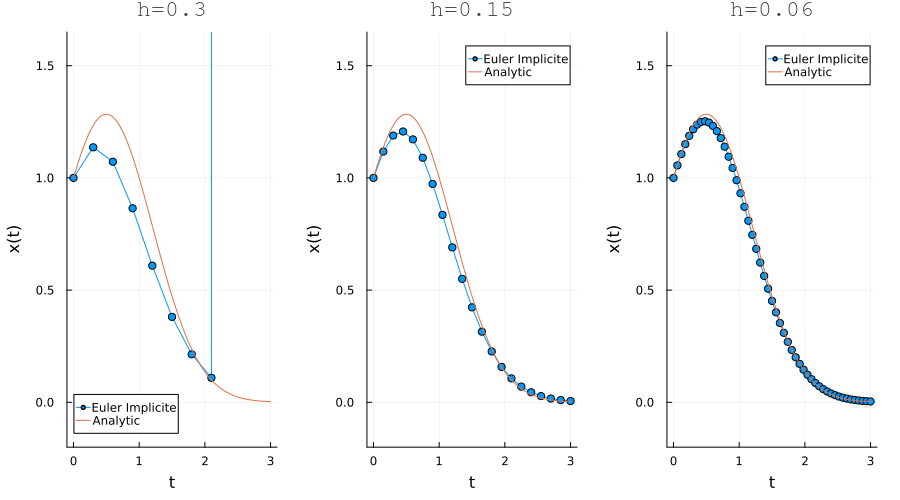

In [116]:
# Convergence de la méthode sur l'exemple
method = :euler_imp
Nspan  = [10, 20, 50]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

#solution en orange, bleu sol approchée via euler qui prend la tangente à chaque fois, plus on met des pts plus ca converge

Méthode d'intégration : Euler Implicite

constante du grand O : K = 0.81871
ordre de convergence : p = 0.99526


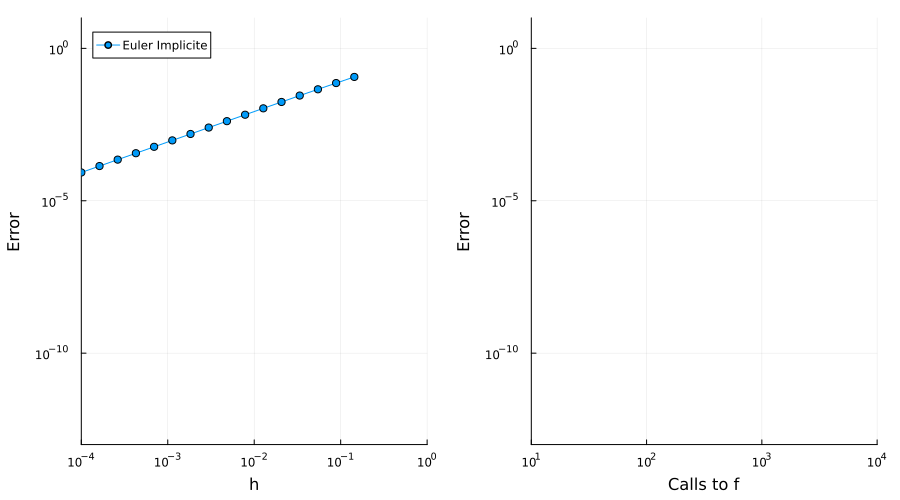

In [117]:
# Ordre de convergence de la méthode
method  = :euler_imp
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 0.2]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_euler_imp = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_euler_imp..., layout=(1, 2), size=(900, 500))

Pour $h \ge 0.2$, l'algorithme s'arrête au nombre d'iterations maximal qu'on s'est fixé.
D'après le théorème 8.2.2 du cours, si $h < \frac{1}{L \max \left( \sum |a_{ij}| \right)}$, alors il existe une unique solution à l’équation. 
Ainsi, h dépend de la constante de Lipschitz. Tant que l'on respecte la condition, on sait que notre l'erreur entre la courbe de la solution réelle et celle de la solution approchée sera très petite.

On voit bien ici que plus le h est grand, plus l'erreur est amplifiée.


## La méthode des trapèzes

La méthode des trapèzes est donnée par le tableau de Butcher :

$$
    \begin{array}{c | c c}
        0       & 0     & 0     \\[0.2em]
        1       & 1/2   & 1/2   \\[0.2em]
        \hline
                & 1/2   & 1/2   \\
    \end{array}
$$

### Exercice 2

1. Implémenter la méthode des trapèzes avec le point fixe.
2. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
3. Tracer l'erreur globale de la méthode des trapèzes. Quel est l'ordre de convergence de la méthode des trapèzes ?

In [118]:
# Implémentation de la méthode des trapèzes
function trapezes(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0 
    x = x0
    ts = [t0]
    xs = [x0]

    G(K) = [K[1],f(t+h,x+(h/2).*(K[1]+K[2]))]

    for i in 1:N
        K = [f(t,x), f(t,x)]
        n_iter = 0
        tol = norm(K[2]-G(K)[2])

        while(tol>tolmin) & (n_iter < n_iter_max)
            K = G(K)
            tol = norm(K[2]-G(K)[2])
            n_iter = n_iter + 1
        end 

        x = x + (h/2).*(K[1]+f(t+h,x.+(h/2).*(K[1]+K[2]))) 
        t = t+h 
        push!(ts, t)
        push!(xs, x)
        
    end    
    return ts, xs
end;

Méthode d'intégration : Trapèzes


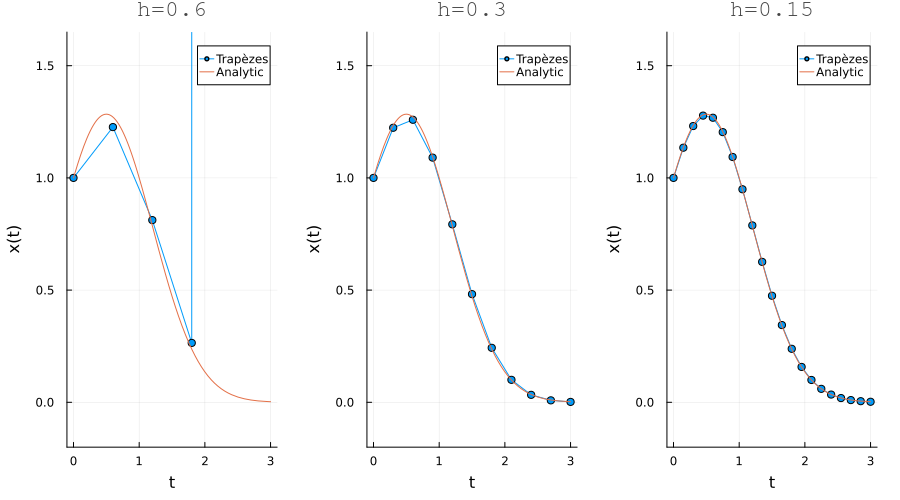

In [119]:
# Convergence de la méthode sur l'exemple
method = :trapezes
Nspan  = [5,10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Trapèzes

constante du grand O : K = 0.13892


ordre de convergence : p = 1.99148


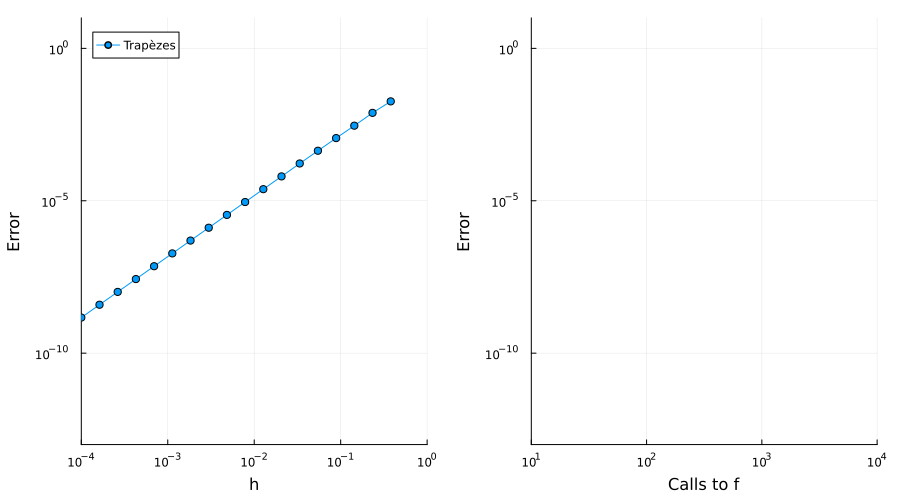

In [120]:
# Ordre de convergence de la méthode
method  = :trapezes
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 0.6]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_trapeze = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_trapeze..., layout=(1, 2), size=(900, 500))

La méthode des trapèzes est d'ordre 2.

## La méthode de Gauss à 2 étages

La méthode de Gauss à 2 étages est donnée par le tableau de Butcher :

$$
    \begin{array}{c | c c}
        1/2 - \sqrt{3}/6     & 1/4  & 1/4 - \sqrt{3}/6  \\[0.2em]
        1/2 + \sqrt{3}/6     & 1/4 + \sqrt{3}/6 & 1/4   \\[0.2em]
        \hline
        & 1/2 & 1/2 \\
    \end{array}
$$

### Exercice 3

1. Implémenter la méthode de Gauss à 2 étages avec le point fixe.
2. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
3. Tracer l'erreur globale de la méthode de Gauss à 2 étages. Quel est l'ordre de convergence de la méthode de Gauss à 2 étages ?

In [121]:
# Implémentation de la méthode de Gauss
function gauss(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0 
    x = x0
    ts = [t0]
    xs = [x0]

    G(K) = [f(t+h*(0.5-sqrt(3)/6), x+h.*(1/4*K[1] + (1/4- sqrt(3)/6).*K[2])),f(t+(0.5+sqrt(3)/6)*h, x+h.*((1/4+sqrt(3)/6).*K[1] + 1/4*K[2]))]

    for i in 1:N
        K = [f(t,x), f(t,x)]
        n_iter = 0
        tol = norm(K-G(K))

        while(tol>tolmin) & (n_iter < n_iter_max)
            K = G(K)
            tol = norm(K-G(K))
            n_iter = n_iter + 1
        end 

        x = x + (h/2)*(f(t+h*(0.5-sqrt(3)/6), x+h*(1/4*K[1] + (1/4- sqrt(3)/6)*K[2])) + f(t+(0.5+sqrt(3)/6)*h, x+h*((1/4+sqrt(3)/6)*K[1] + 1/4*K[2])))
        t = t+h 
        push!(ts, t)
        push!(xs, x)
        
    end    
    return ts, xs
end;

Méthode d'intégration : Gauss


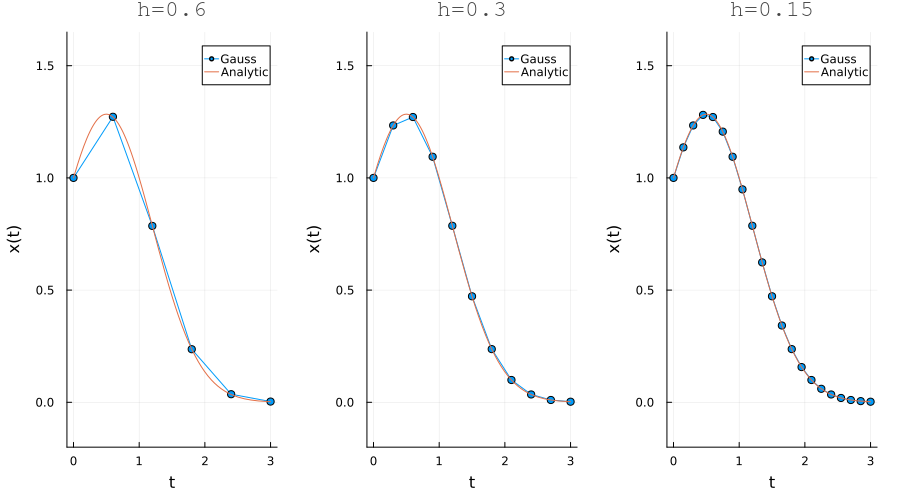

In [122]:
# Convergence de la méthode sur l'exemple
method = :gauss
Nspan  = [5,10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Gauss

constante du grand O : K = 2.0e-5


ordre de convergence : p = 2.02673


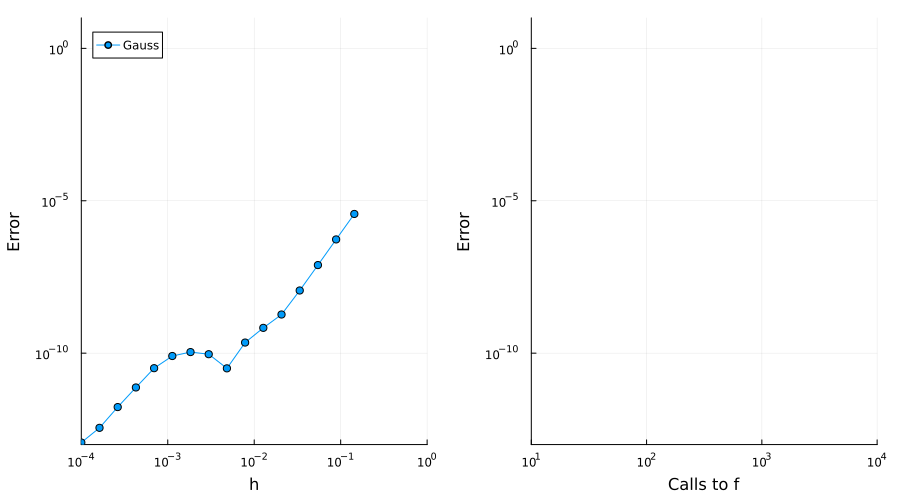

In [123]:
# Ordre de convergence de la méthode
method  = :gauss
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 0.2]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_gauss = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_gauss..., layout=(1, 2), size=(900, 500))

La méthode de Gauss est d'ordre 2.

## Un autre exemple

On considère à partir de maintenant l'équation différentielle en dimension 2 :

$$
    \dot{x}_1(t) = x_2(t), \quad \dot{x}_2(t) = - x_1(t).
$$

On peut montrer facilement que la norme de $x(t) = (x_1(t), x_2(t))$ est constante le long des solutions :

$$
    \frac{\mathrm{d}}{\mathrm{d} t} \|x(t)\|^2 = 2\, \left( x(t) \,|\, \dot{x}(t) \right) =  2 \left( x_1(t) x_2(t) - x_2(t) x_1(t) \right) = 0.
$$

### Exercice 4

On considère le problème de Cauchy associé de condition initiale $x_0 = (1, 0)$.

1. Afficher l'approximation de la solution sur $[0, 10]$ pour les méthodes :
- Euler explicite ;
- Euler implicite ;
- Trapèzes ;
- Gauss à 2 étages.
2. Commentaires.

**Attention :** vous ferez un affichage dans le plan $(x_1, x_2)$. Vous fixerez le nombre de pas à $N=100$.

In [124]:
# Implémentation de la méthode d'Euler
function euler_exp(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    for i in 1:N
        x = x + h*f(t,x) 
        t = t+h 
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

In [125]:
tspan = (0.0, 10.0);  # Intervalle de temps
N = 100
X0 = [1.0,0.0]

F(t,X) = [X[2], -X[1]] 

F (generic function with 1 method)

### Solution exacte

Le problème de Cauchy peut s'écrire comme suit : 
$$
X'(t) = A \cdot X(t)
$$

avec 
$$
X = \begin{pmatrix}
x_1 \\
x_2
\end{pmatrix}
$$

et 
$$
A = \begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix}
$$


On sait que la solution de ce problème est : 
$$
X(t) = e^{At} \cdot X_0
$$

avec 
$$
X_0 = \begin{pmatrix}
1 \\
0
\end{pmatrix}
$$


Après avoir fait le calcul, on obtient 
$$
x(t) = \begin{pmatrix}
\cos(t) \\
-\sin(t)
\end{pmatrix}
$$


In [126]:
sol_exacte(t) = [cos(t), -sin(t)]

ts_exact = range(tspan[1], stop=tspan[2], length=N)  
xs_exact = [exact_solution(t) for t in ts_exact]

100-element Vector{Vector{Float64}}:
 [1.0, -0.0]
 [0.9949028158568303, -0.1008384202581046]
 [0.9796632259996998, -0.2006488565226854]
 [0.9544365884201449, -0.2984138044476411]
 [0.9194800727522776, -0.3931366121483298]
 [0.8751500385908233, -0.48385164043793466]
 [0.82189840263017, -0.5696341069089657]
 [0.7602680316591507, -0.6496095135057065]
 [0.6908872083770674, -0.7229625614794605]
 [0.6144632264484674, -0.7889454628442574]
 ⋮
 [-0.973010682179788, -0.23076007532505177]
 [-0.9913205490138658, -0.13146698864295842]
 [-0.9995245290814802, -0.03083367906114098]
 [-0.9975389879884077, 0.07011396040064677]
 [-0.9853841670717991, 0.1703468323280965]
 [-0.9631839770525324, 0.26884312591038406]
 [-0.9311647348436916, 0.3645987336558887]
 [-0.8896528563926016, 0.45663748763377376]
 [-0.8390715290764524, 0.5440211108893698]

### Approximation de la solution

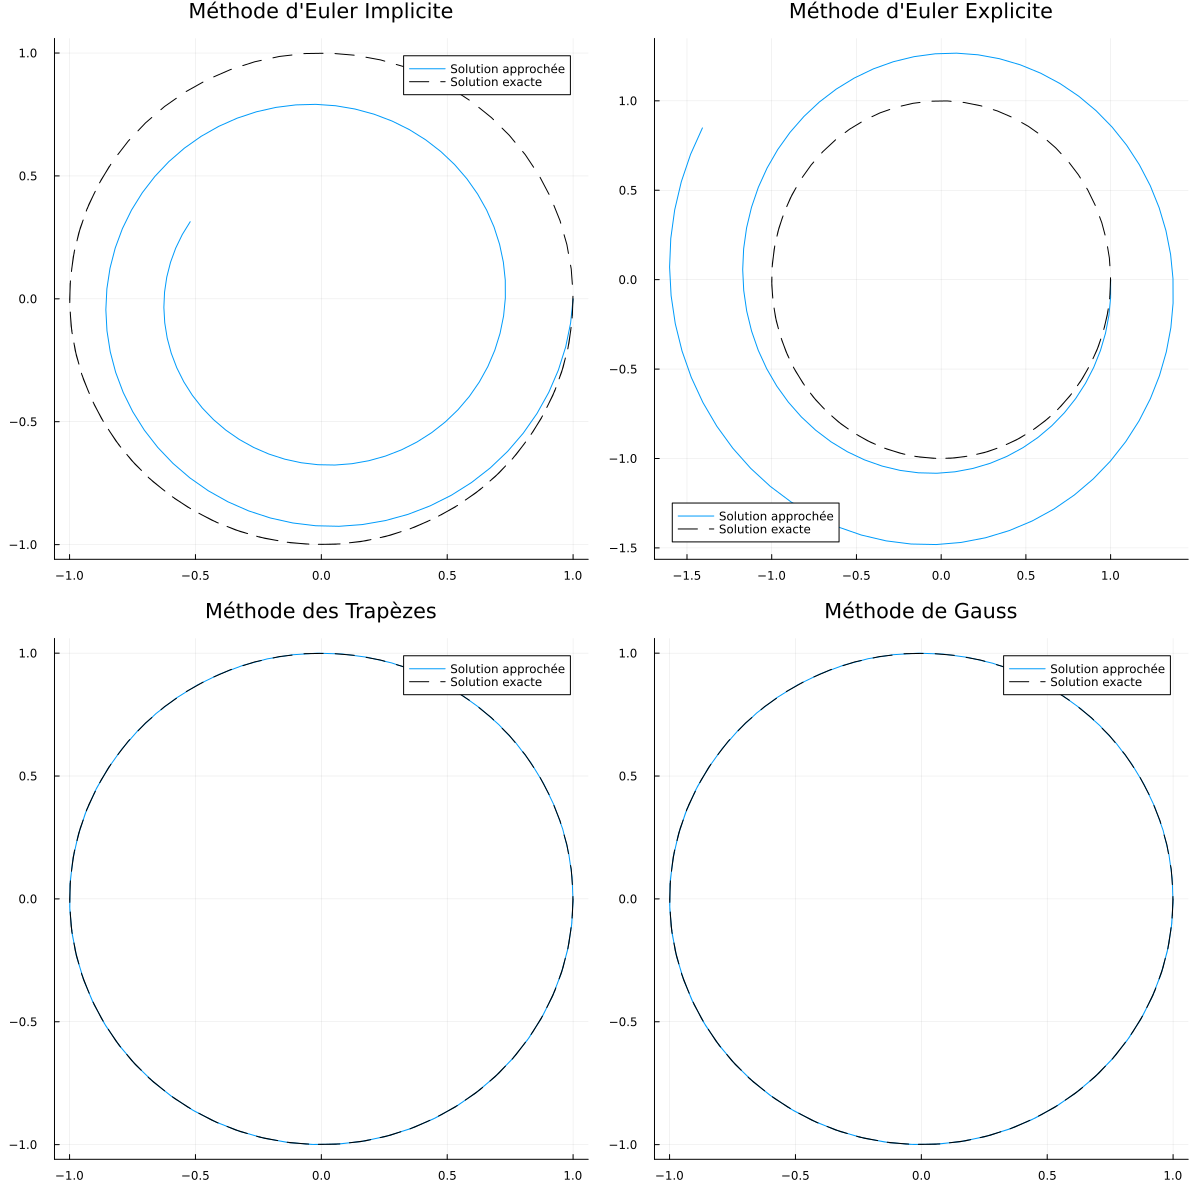

In [127]:
ts, xs = euler_imp(F, X0, tspan, N)
p1 = plot([X[1] for X in xs], [X[2] for X in xs], title="Méthode d'Euler Implicite", label="Solution approchée")
plot!([X[1] for X in exact_xs], [X[2] for X in exact_xs], label="Solution exacte", linestyle=:dash, color=:black)

ts, xs = euler_exp(F, X0, tspan, N)
p2 = plot([X[1] for X in xs], [X[2] for X in xs], title="Méthode d'Euler Explicite", label="Solution approchée")
plot!([X[1] for X in exact_xs], [X[2] for X in exact_xs], label="Solution exacte", linestyle=:dash, color=:black)


ts, xs = trapezes(F, X0, tspan, N)
p3 = plot([X[1] for X in xs], [X[2] for X in xs], title="Méthode des Trapèzes", label="Solution approchée")
plot!([X[1] for X in exact_xs], [X[2] for X in exact_xs], label="Solution exacte", linestyle=:dash, color=:black)


ts, xs = gauss(F, X0, tspan, N)
p4 = plot([X[1] for X in xs], [X[2] for X in xs], title="Méthode de Gauss", label="Solution approchée")
plot!([X[1] for X in exact_xs], [X[2] for X in exact_xs], label="Solution exacte", linestyle=:dash, color=:black)


plot(p1, p2, p3, p4, layout = (2, 2), size=(1200,1200))


Pour la méthode d'Euler implicite, la solution approchée part de X0 et a l'air de converger tandis que la méthode d'Euler explicite a l'air de diverger. 
Il faudrait donc prendre un pas h plus petit et donc augmenter N pour être sur que la solution approchée converge vers la solution exacte. 

Pour les méthodes des trapèzes et de Gauss, la solution approchée converge vers la solution exacte pour N fixé à 100. Toutefois, lorsque l'on change la valeur de N, et qu'on la diminue, ie on augmente le pas, la solution converge moins bien. Ce sont donc des méthodes qui sont également sensibles au pas de temps.

De plus, les méthodes des trapèzes et de Gauss sont d'ordre 2, donc convergent plus rapidement. Cela donc explique le fait que pour N=100, elles convergent vers la solution maximale et l'erreur est très faible.
Toutefois, les méthodes d'Euler sont d'ordre 1, il leur faut donc plus d'itérations pour converger. D'où la nécessité d'augmenter N et donc de diminuer le pas de temps. 